In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import spacy
import nltk
from bs4 import BeautifulSoup
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer
from tqdm import tqdm
from wordsegment import load, segment
from autocorrect import Speller
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from nltk import word_tokenize
from collections import defaultdict, Counter
import pyLDAvis
from pyLDAvis import gensim as pLDAg
from wordcloud import WordCloud, STOPWORDS
load()
spell = Speller()

In [13]:
df =pd.read_csv('data/tweets_normalized.csv')
df.head()

,id,tweet,tweet_normalized
0,1635430535047811073,"""Please help stop college vaccine mandates by ...",please help stop college vaccine mandate fill ...
1,1635430534657593347,RT @SandraYozipovic: Alberta woman's COVID-19 ...,rts ray oz ipo vic alberta woman covid19van in...
2,1635430531767865344,RT @amuse: CBS is now admitting Fauci funded c...,rt abuse cbs admit face fund coronavirus gain ...
3,1635430530735824897,@RonFilipkowski I take no responsibility for C...,ron flip row ski take responsibility co vid ba...
4,1635430529813151746,OMG. The 🤡🌎 we live in. 😆\n\nWell done @covid_...,omg live well doc oid parent httpstcoezm2gmkgph


Number of Characters

<AxesSubplot:>

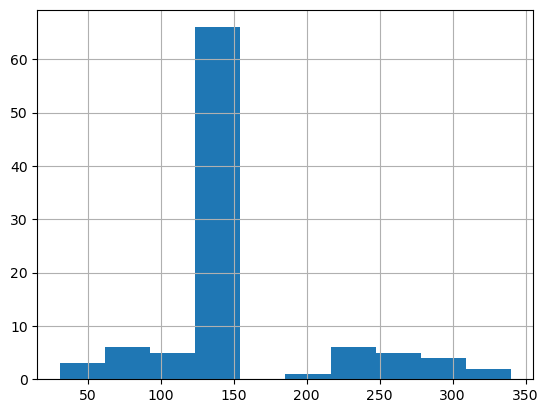

In [15]:
ax = df['tweet'].str.len().hist()
#plt.suptitle("Number of Characters")
ax

In [16]:
fig = ax.get_figure()
fig.savefig('num_of_chars_tweets.pdf')

<AxesSubplot:>

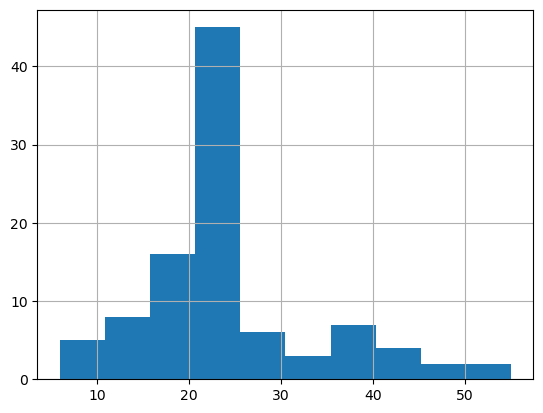

In [17]:
ax = df['tweet'].str.split().map(lambda x: len(x)).hist()
#plt.suptitle("Number of Words")
ax

In [18]:
fig = ax.get_figure()
fig.savefig('num_of_words_tweets.pdf')

Average Word Length

<AxesSubplot:>

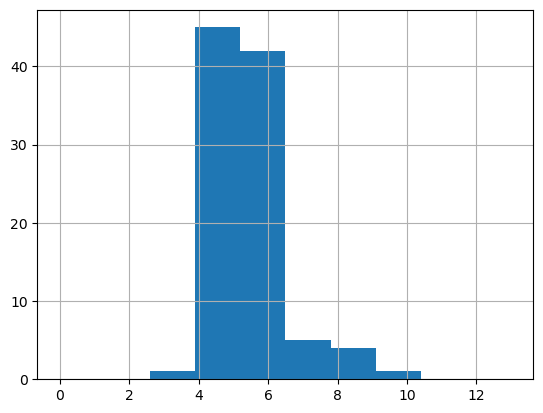

In [19]:
ax = df['tweet'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist(range=[0,13])
#plt.suptitle("Average Word Length")
ax

In [20]:
fig = ax.get_figure()
fig.savefig('avg_word_length_tweet.pdf')

Count Stopwords

In [21]:
stopwords=nltk.corpus.stopwords.words('english')

<BarContainer object of 10 artists>

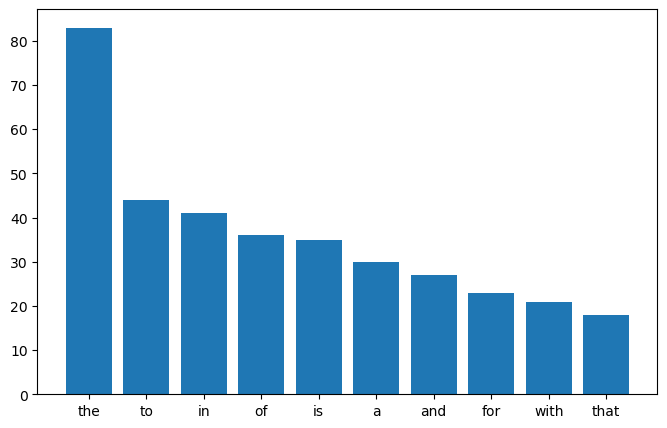

In [23]:
corpus=[]
new = df['tweet'].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]

dic=defaultdict(int)
for word in corpus:
    if word in stopwords:
        dic[word]+=1
top= sorted(dic.items(), key=lambda x:x[1], reverse=True)[:10]
x,y=zip(*top)
fig, ax = plt.subplots(figsize=(8,5))
ax = plt.bar(x,y)
#plt.suptitle("Count of Stopwords")
ax

In [25]:
#fig = ax.get_figure()
fig.savefig('Stopword Count_tweet.pdf')

<AxesSubplot:>

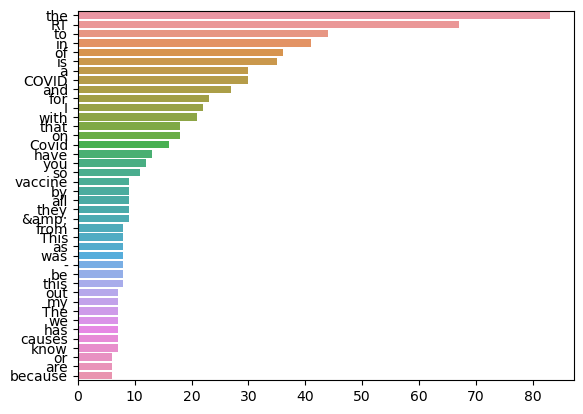

In [27]:
counter=Counter(corpus)
most=counter.most_common()

x, y = [], []
for word, count in most[:40]:
    #if (word not in stopwords):
    x.append(word)
    y.append(count)
ax =sns.barplot(x=y, y=x)
ax

In [ ]:
fig.savefig('Top Words.pdf')

Ngram exploration

In [28]:
def get_top_ngrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n,n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

<AxesSubplot:>

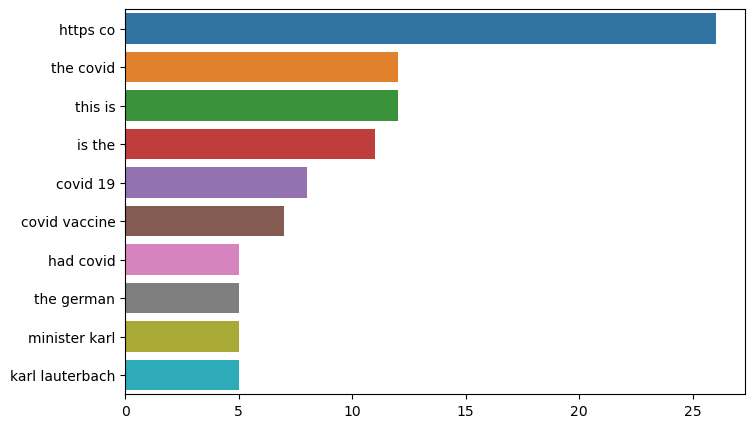

In [29]:
top_n_bigrams = get_top_ngrams(df['tweet'],2)[:10]
x,y = map(list, zip(*top_n_bigrams))
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.barplot(x=y, y=x)
#plt.suptitle("Top Bigrams")
ax

In [30]:
fig.savefig('bigrams_tweets.pdf')

<AxesSubplot:>

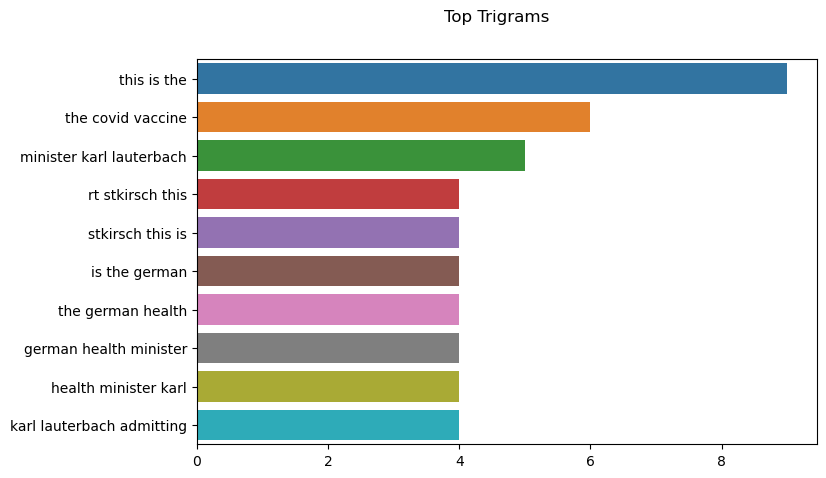

In [31]:
top_tri_grams = get_top_ngrams(df['tweet'],n=3)
x,y = map(list, zip(*top_tri_grams))
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.barplot(x=y, y=x)
plt.suptitle("Top Trigrams")
ax

In [32]:
fig.savefig('trigrams_tweets.pdf')

Preprocessing

In [33]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ramon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [34]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ramon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [35]:
def preprocess_data(df):
    corpus = []
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    for tweet in df['tweet']:
        words = [w for w in word_tokenize(tweet) if (w not in stopwords)]
        words = [lem.lemmatize(w) for w in words if len(w)>2]
        corpus.append(words)
    return corpus

In [36]:
corpus = preprocess_data(df)

Topic Modeling

In [37]:
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [38]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = 4, id2word = dic, passes = 10, workers = 2)
lda_model.show_topics()

[(0,
  '0.015*"Covid" + 0.015*"..." + 0.013*"http" + 0.011*"know" + 0.009*"bailouts" + 0.009*"COVID" + 0.008*"government" + 0.008*"cause" + 0.006*"miscarriage" + 0.006*"digital"'),
 (1,
  '0.011*"http" + 0.011*"Covid" + 0.011*"COVID" + 0.008*"amp" + 0.006*"refused" + 0.006*"first" + 0.006*"weakness" + 0.004*"get" + 0.004*"today" + 0.004*"case"'),
 (2,
  '0.014*"COVID" + 0.012*"http" + 0.009*"vaccine" + 0.009*"Covid" + 0.007*"covid" + 0.005*"virus" + 0.005*"Please" + 0.005*"look" + 0.005*"symptom" + 0.005*"Pfizer"'),
 (3,
  '0.022*"COVID" + 0.012*"vaccine" + 0.012*"time" + 0.008*"This" + 0.007*"Karl" + 0.007*"German" + 0.007*"Lauterbach" + 0.007*"cause" + 0.007*"serious" + 0.007*"admitting"')]

In [39]:
pyLDAvis.enable_notebook()
vis = pLDAg.prepare(lda_model, bow_corpus, dic)
vis

C:\Users\Ramon\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.131477  0.000327       1        1  29.685337
3     -0.050426 -0.103932       2        1  24.866050
2     -0.026996  0.011694       3        1  24.650902
1     -0.054055  0.091910       4        1  20.797712, topic_info=           Term      Freq     Total Category  logprob  loglift
144         ...  7.000000  7.000000  Default  30.0000  30.0000
367    bailouts  4.000000  4.000000  Default  29.0000  29.0000
152        time  5.000000  5.000000  Default  28.0000  28.0000
175        know  5.000000  5.000000  Default  27.0000  27.0000
248  government  3.000000  3.000000  Default  26.0000  26.0000
..          ...       ...       ...      ...      ...      ...
66          The  1.256722  4.762690   Topic4  -5.4989   0.2380
419        2020  1.256559  2.303510   Topic4  -5.4991   0.9643
302        year  1.256052  4.090546   Topic4  -5.4995   0.3896
402      Cancer  1.255742  2.346351   Topic4  -5.4997   0.9452
269       could  1.255222  2.981346   Topic4  -5.5001   0.7053

[198 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
144       1  0.928190                ...
144       3  0.132599                ...
154       2  0.561989  //t.co/4L2WigDT6S
602       4  0.584175  //t.co/NlclHFLyXn
0         3  0.838195  //t.co/eaCoy8ryvW
...     ...       ...                ...
773       3  0.406045              would
302       2  0.244466               year
302       3  0.244466               year
302       4  0.244466               year
160       2  0.561989                😵‍💫

[224 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

In [40]:
pyLDAvis.save_html(vis, 'pyLDAvis_tweets.html')

Word Cloud

In [41]:
stopwords = set(STOPWORDS)

In [44]:
def show_wordcloud(data):
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=100, max_font_size=30, scale=3, random_state=1)
    wordcloud=wordcloud.generate(str(data))
    fig = plt.figure(1, figsize=(12,12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.savefig('wordcloud_tweets.pdf')
    plt.show()

C:\Users\Ramon\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Ramon\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Ramon\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Ramon\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transpose

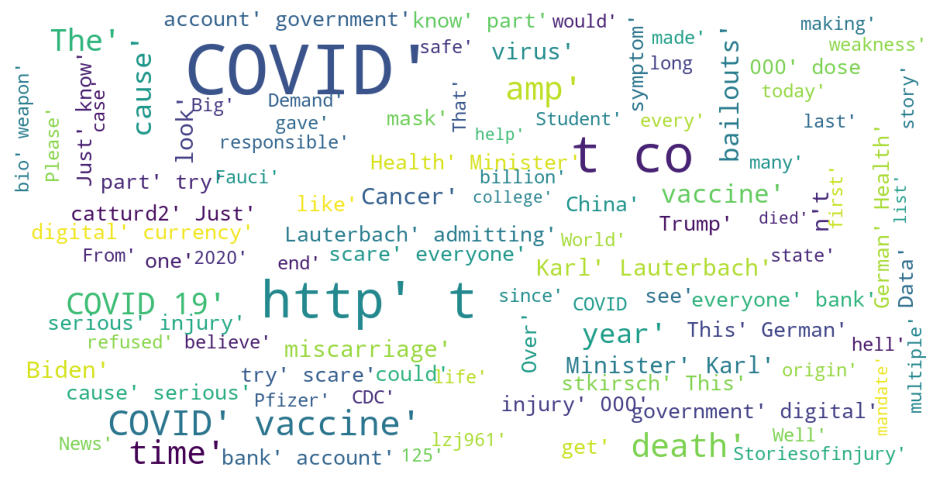

In [43]:
show_wordcloud(corpus)

In [ ]:
df.head()

In [ ]:
dic = gensim.corpora.Dictionary(corpus)
dic.doc2bow(df['comment_text_normalized'].tolist())

In [ ]:
df['comment_text_normalized'].tolist()